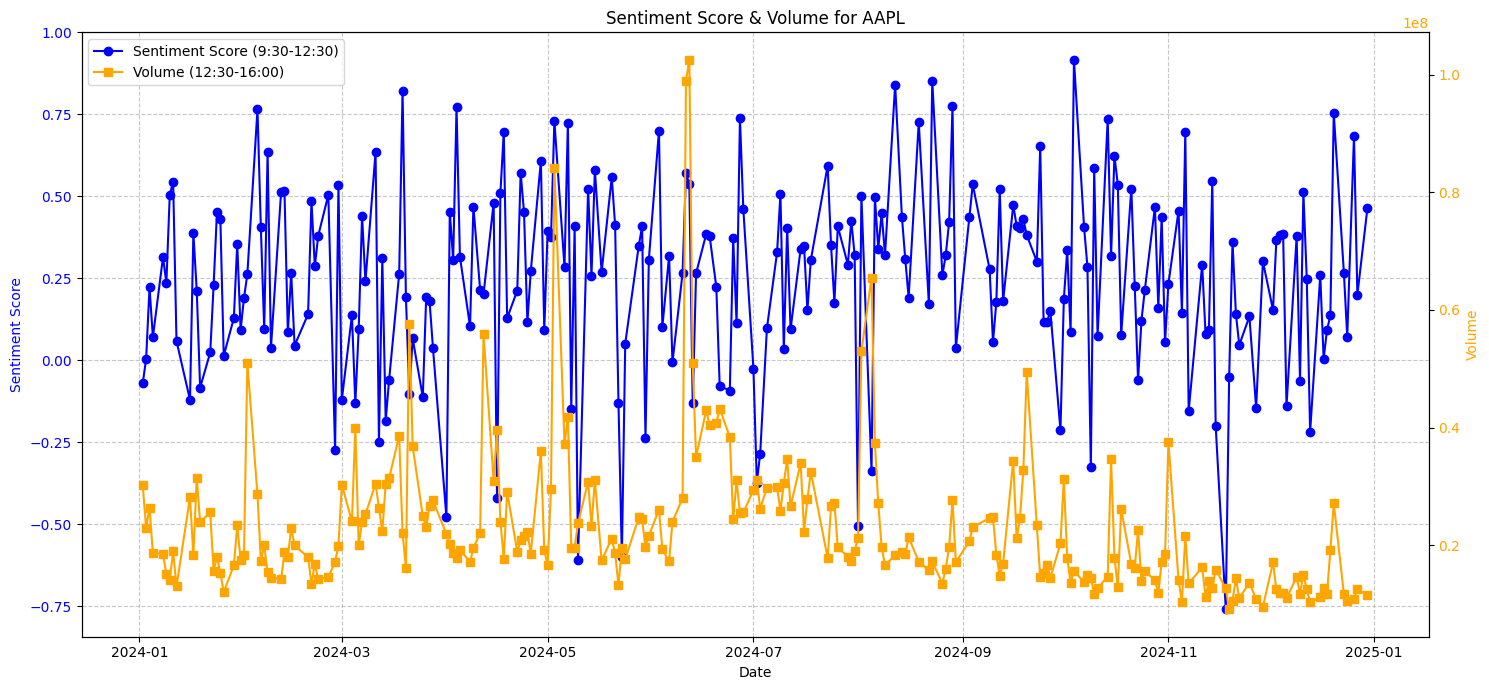

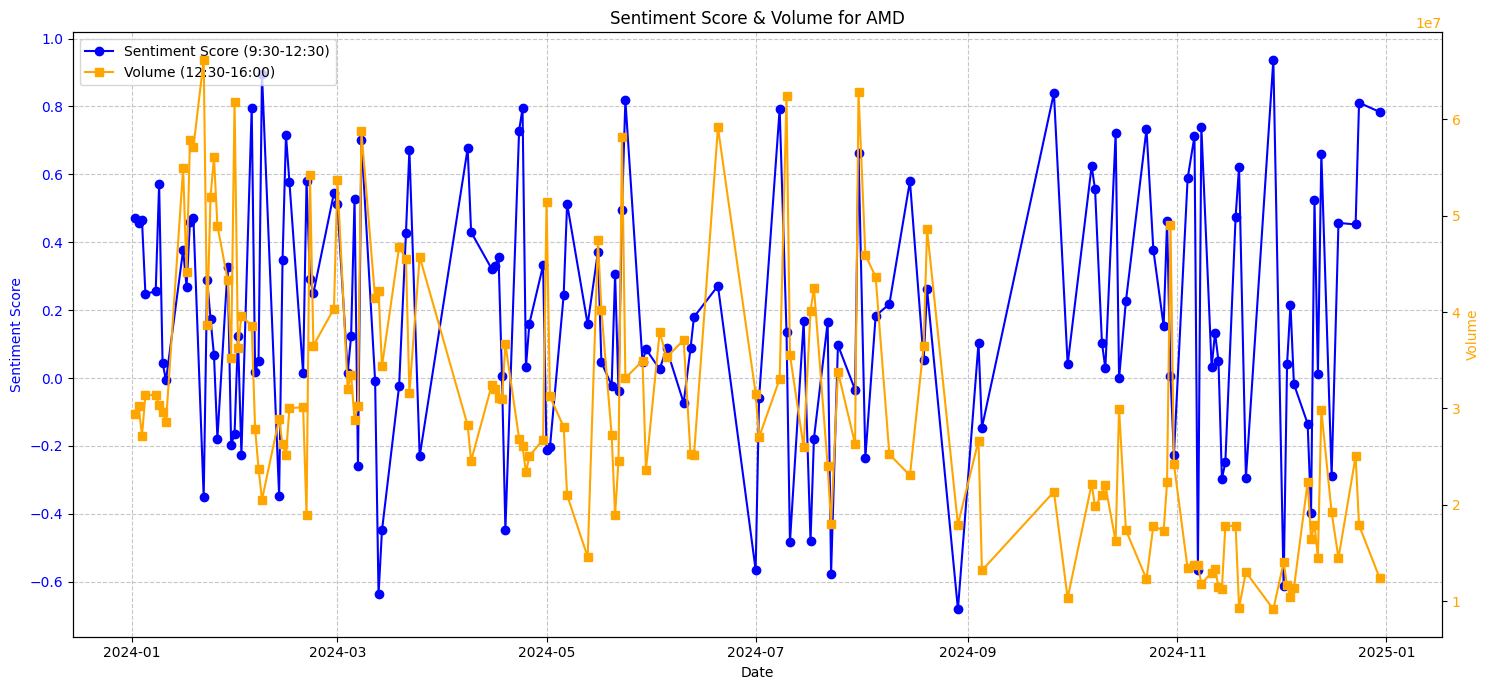

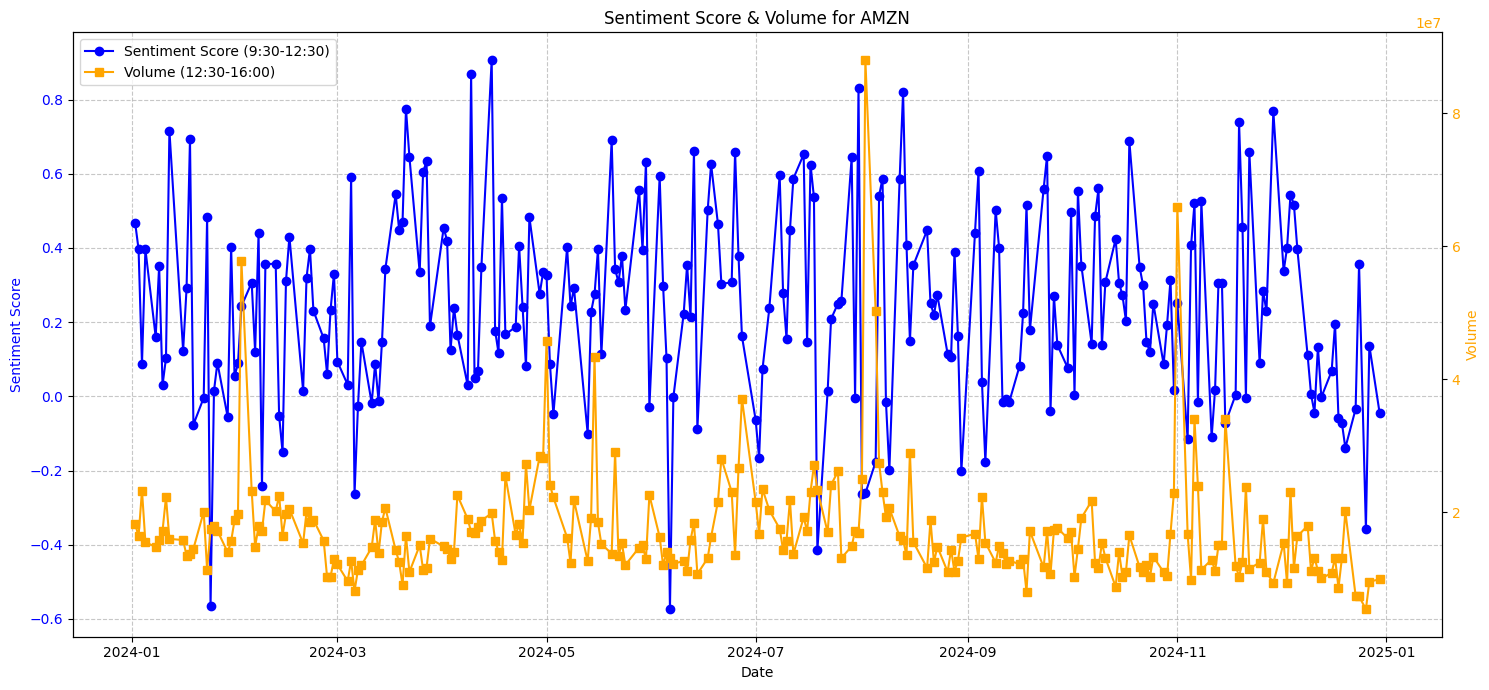

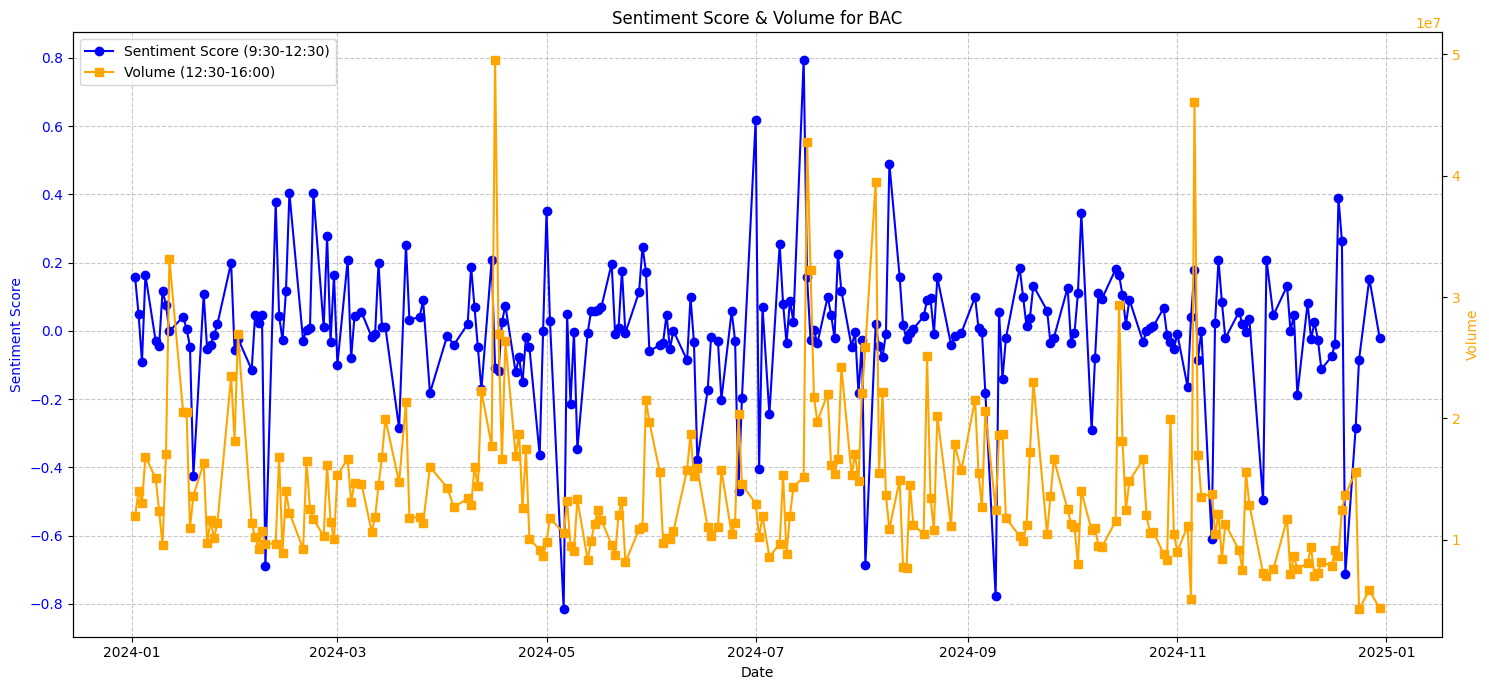

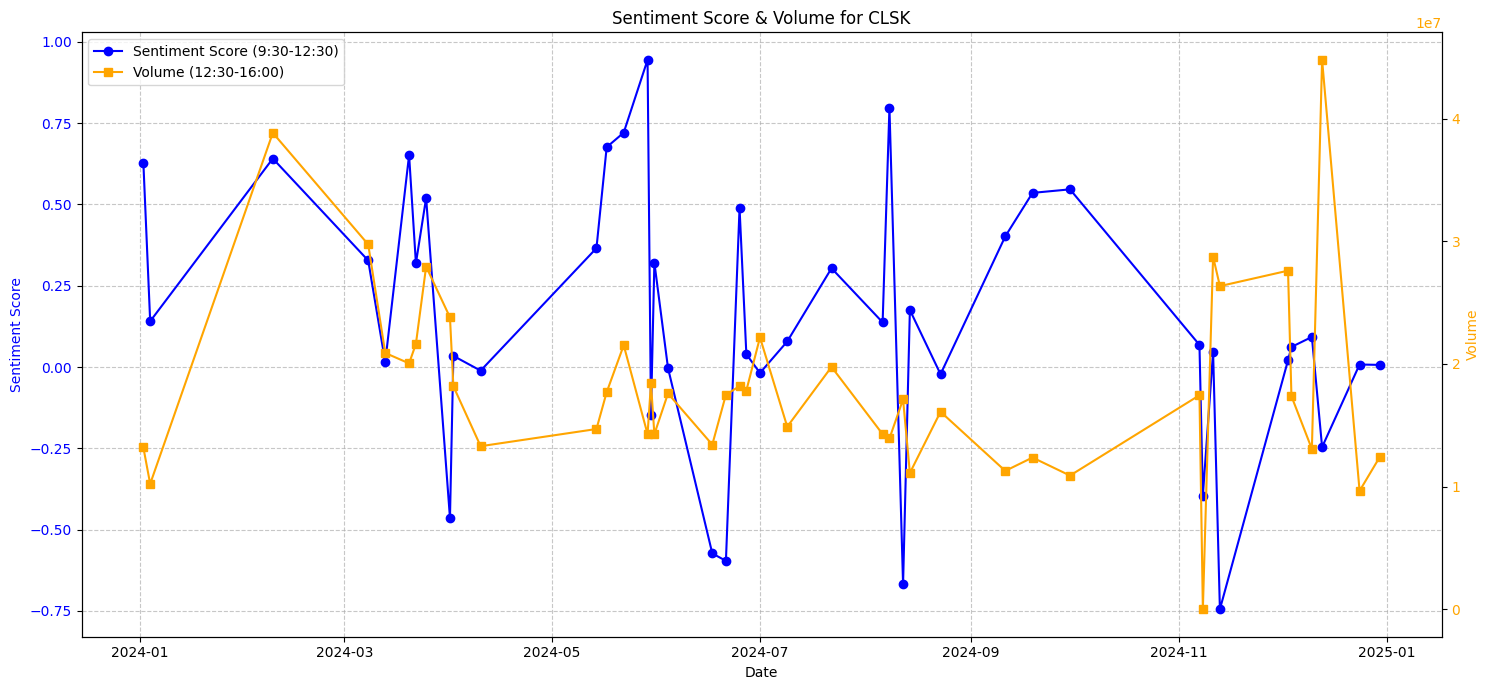

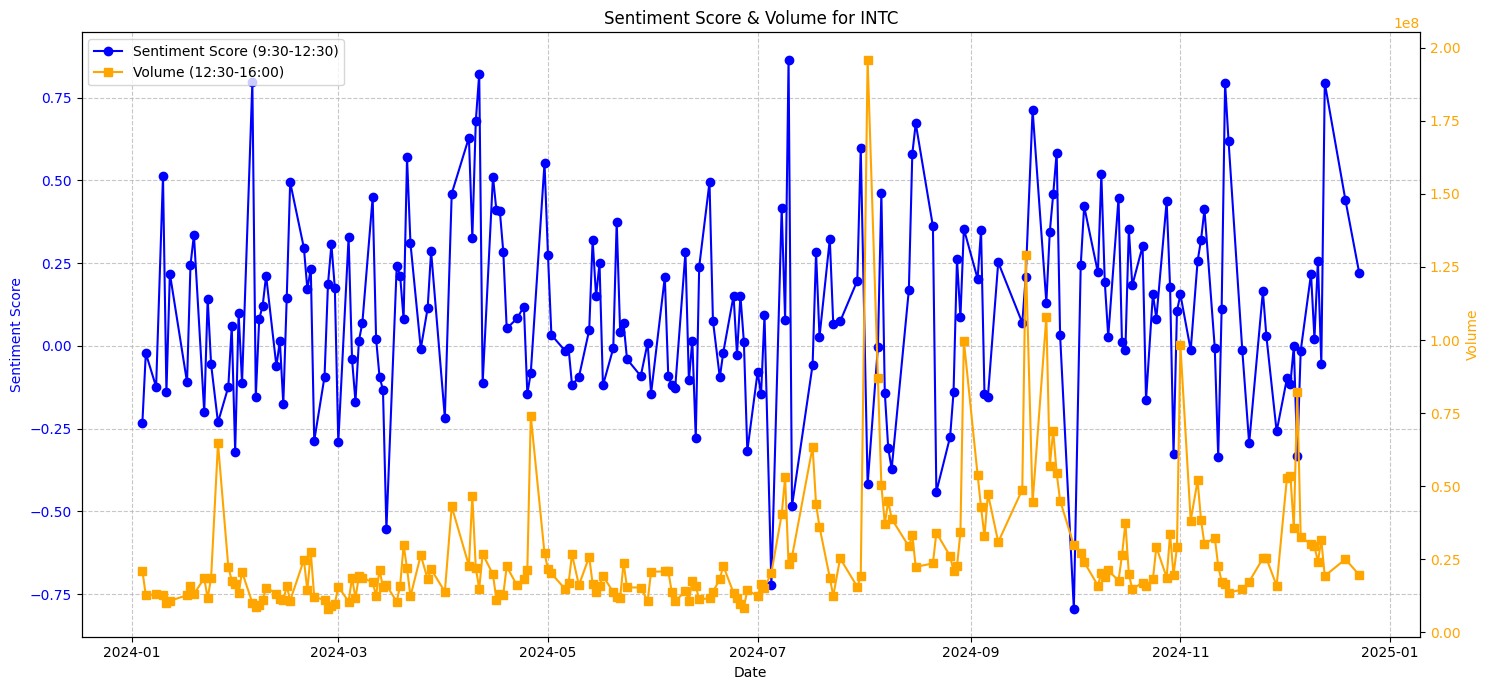

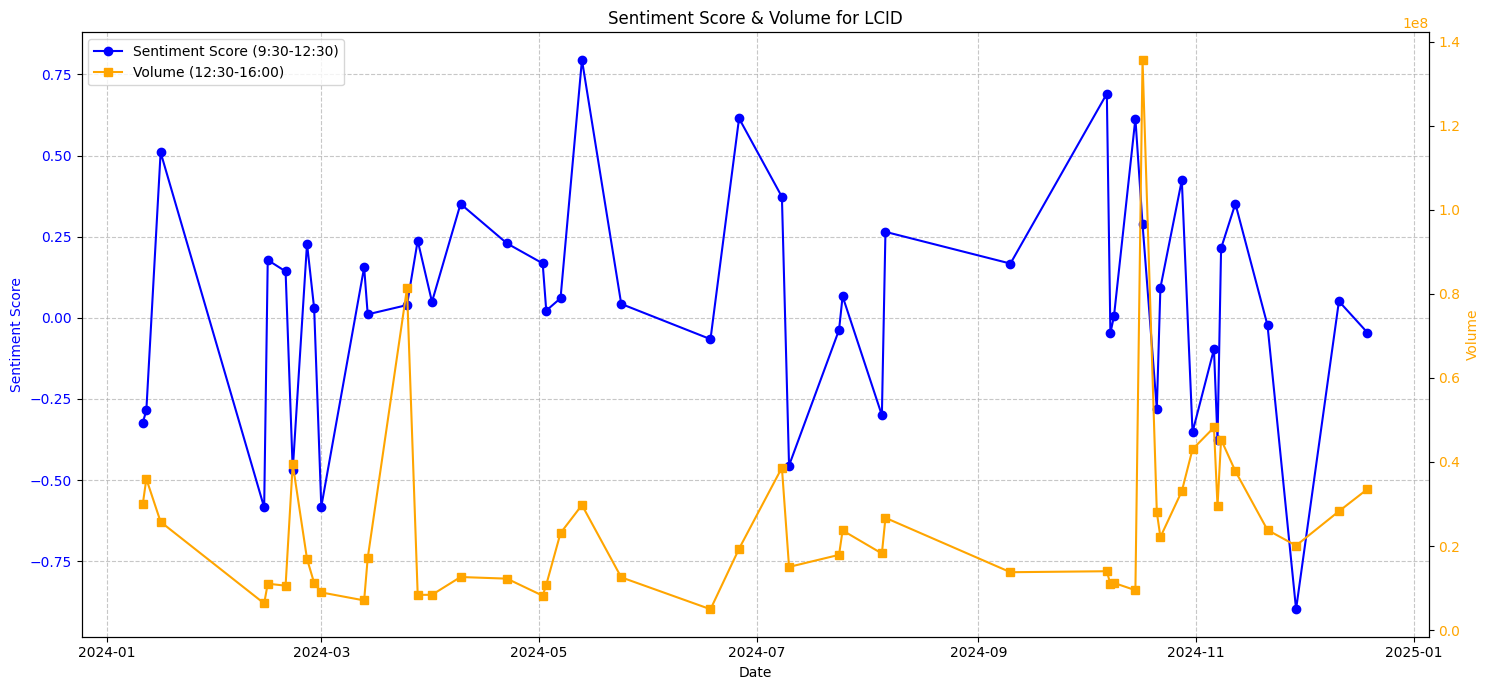

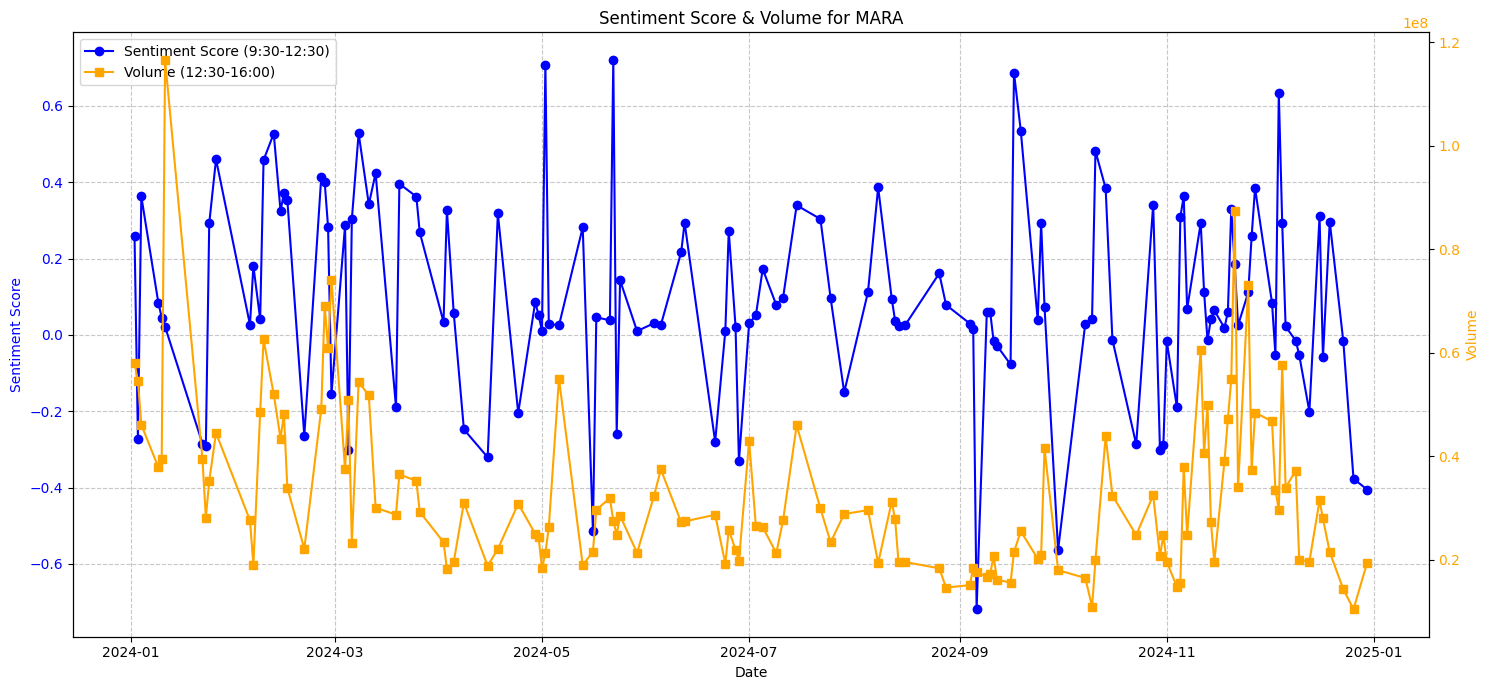

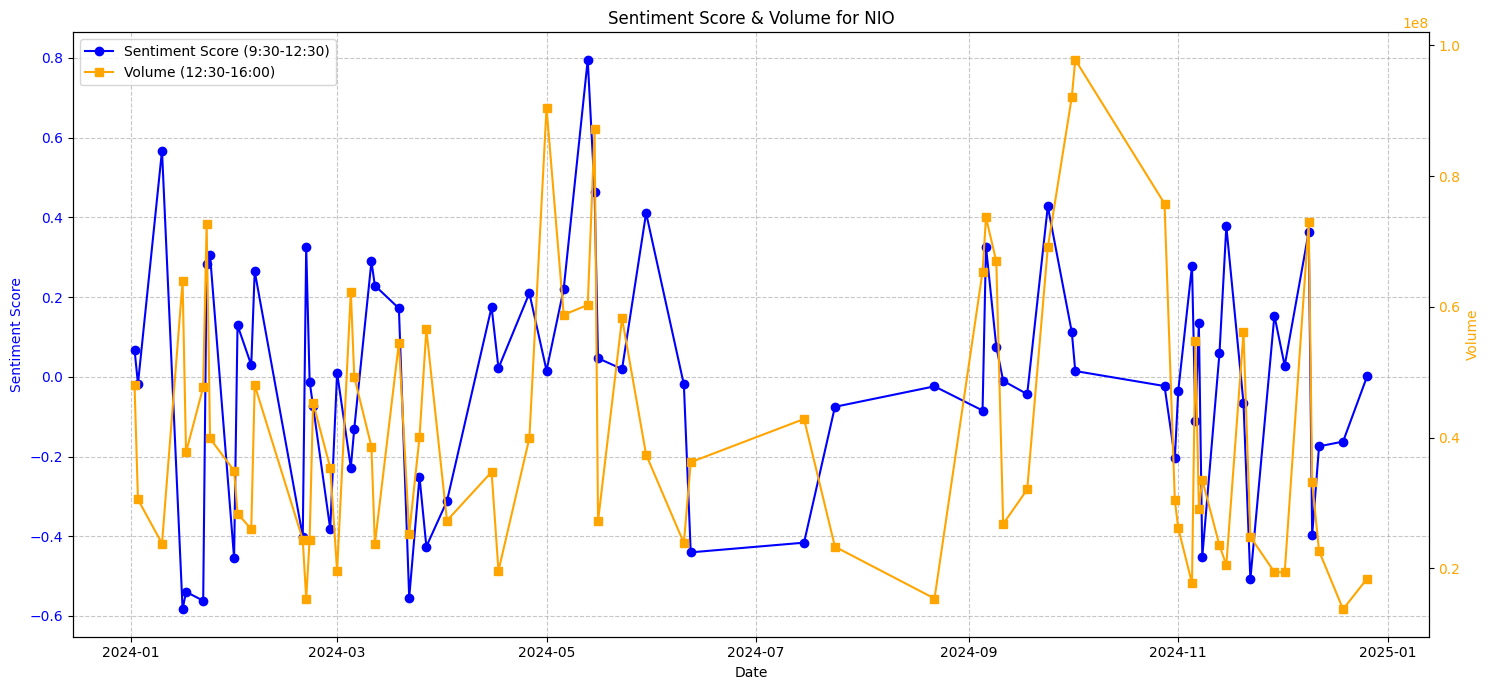

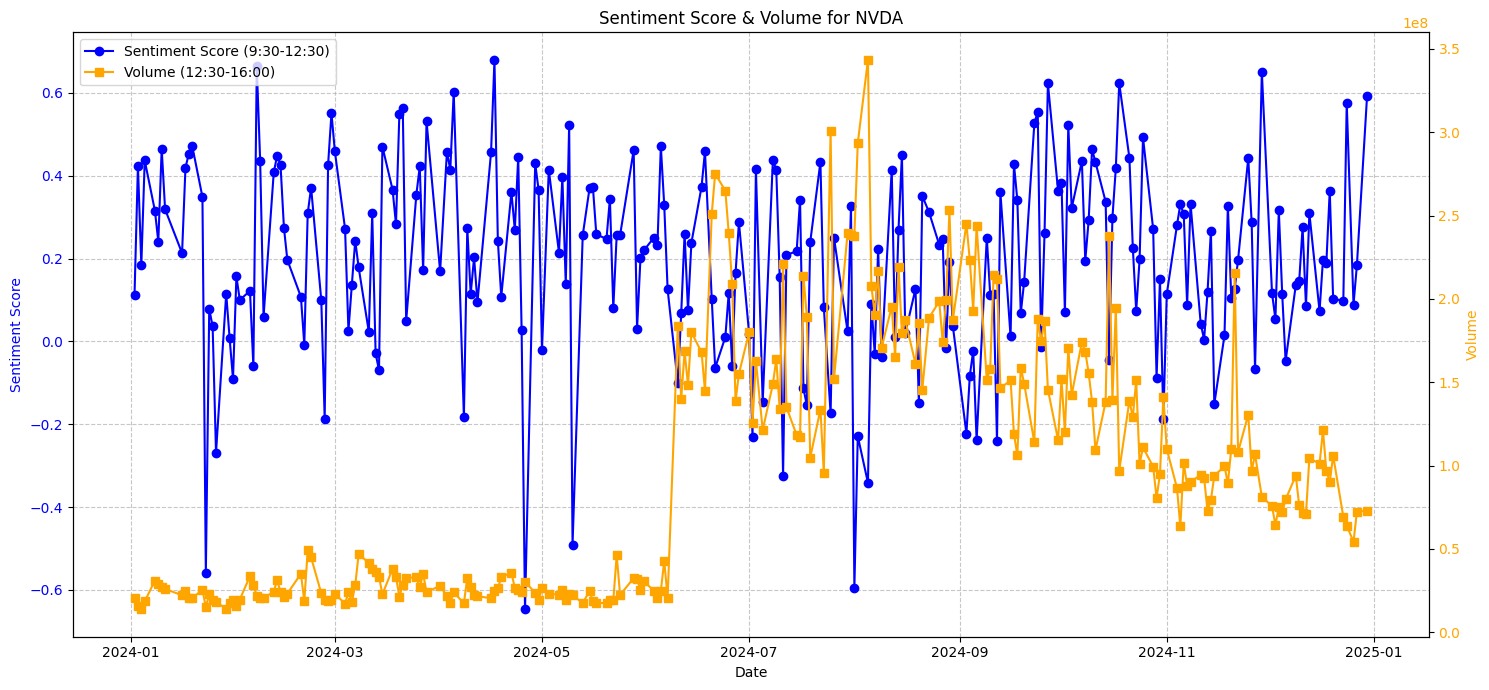

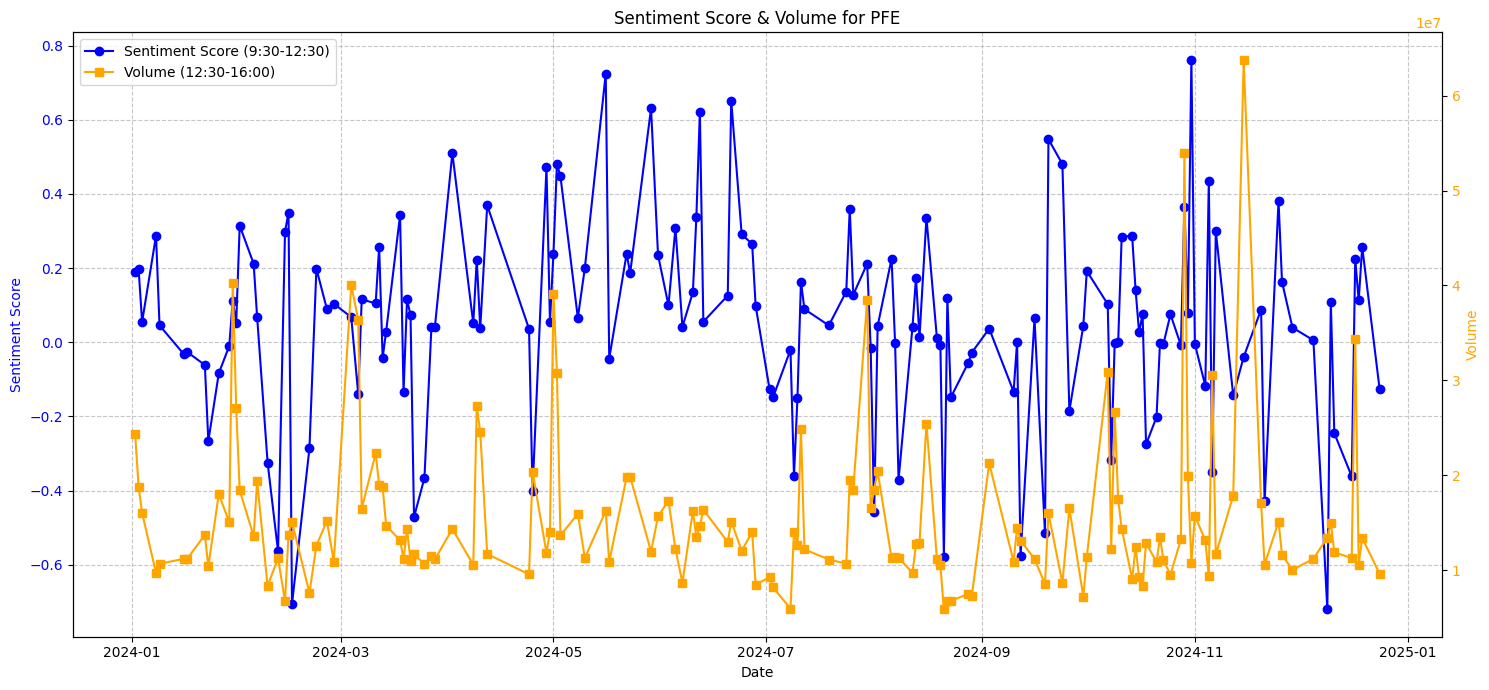

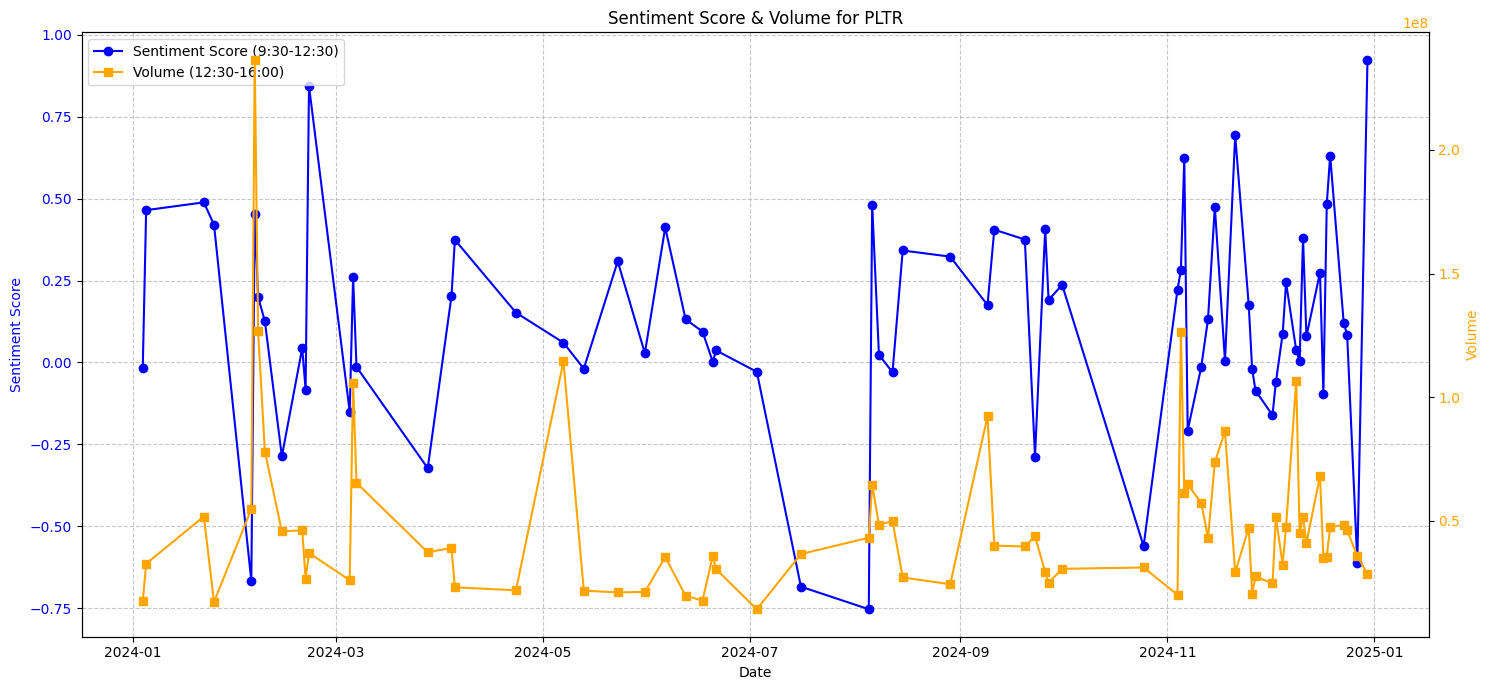

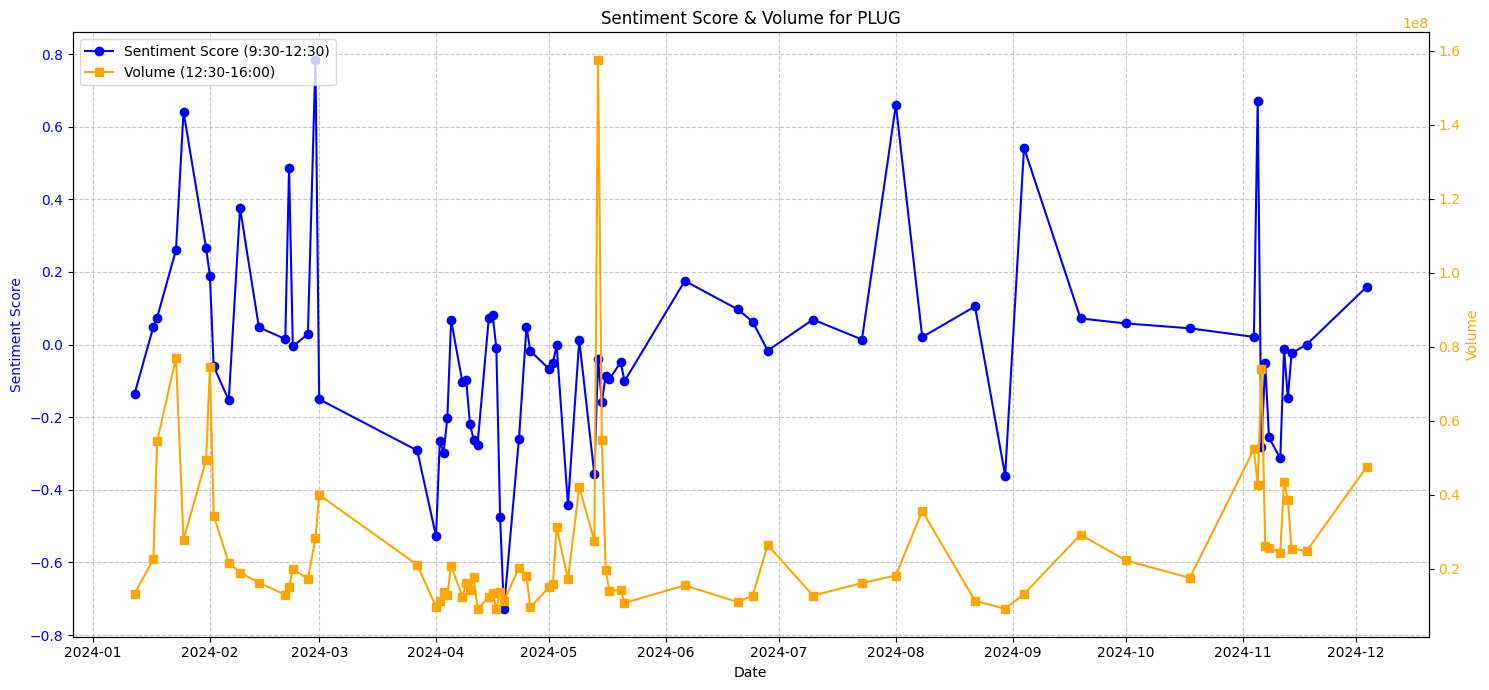

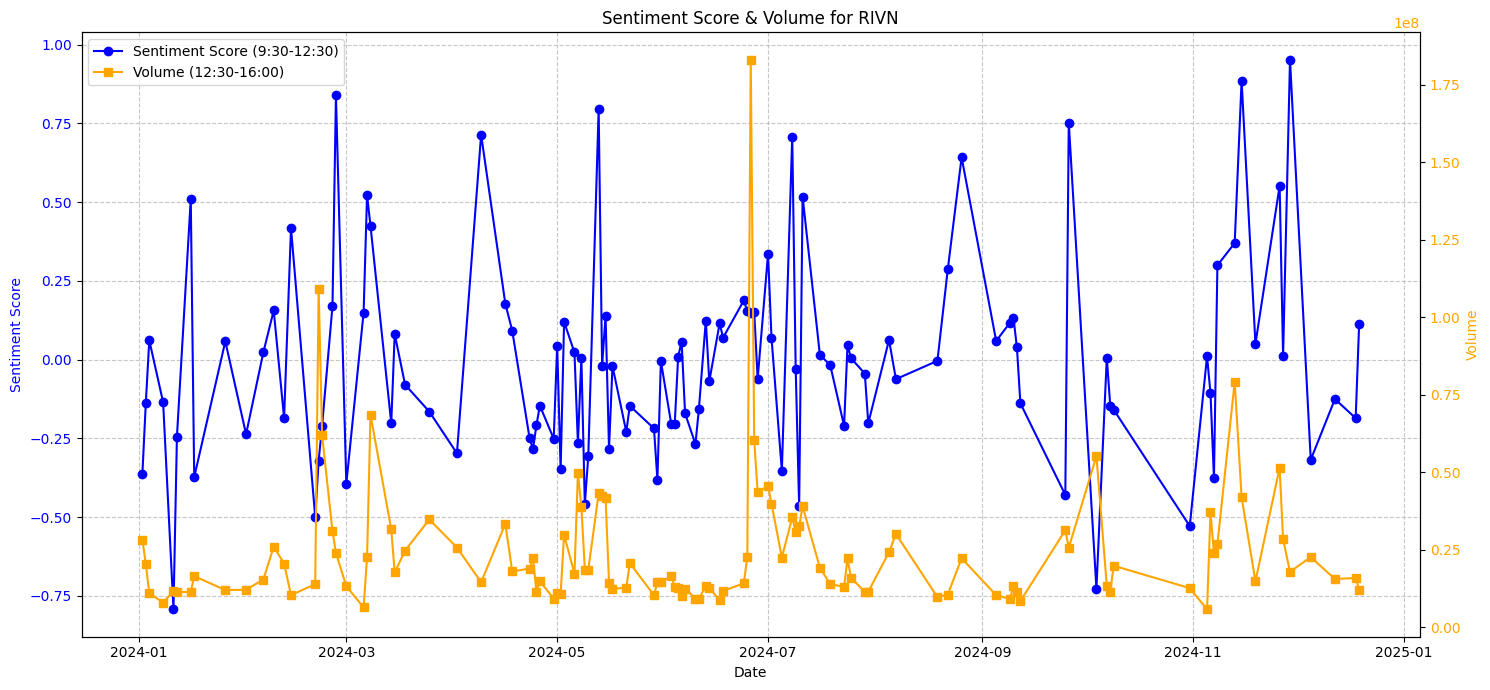

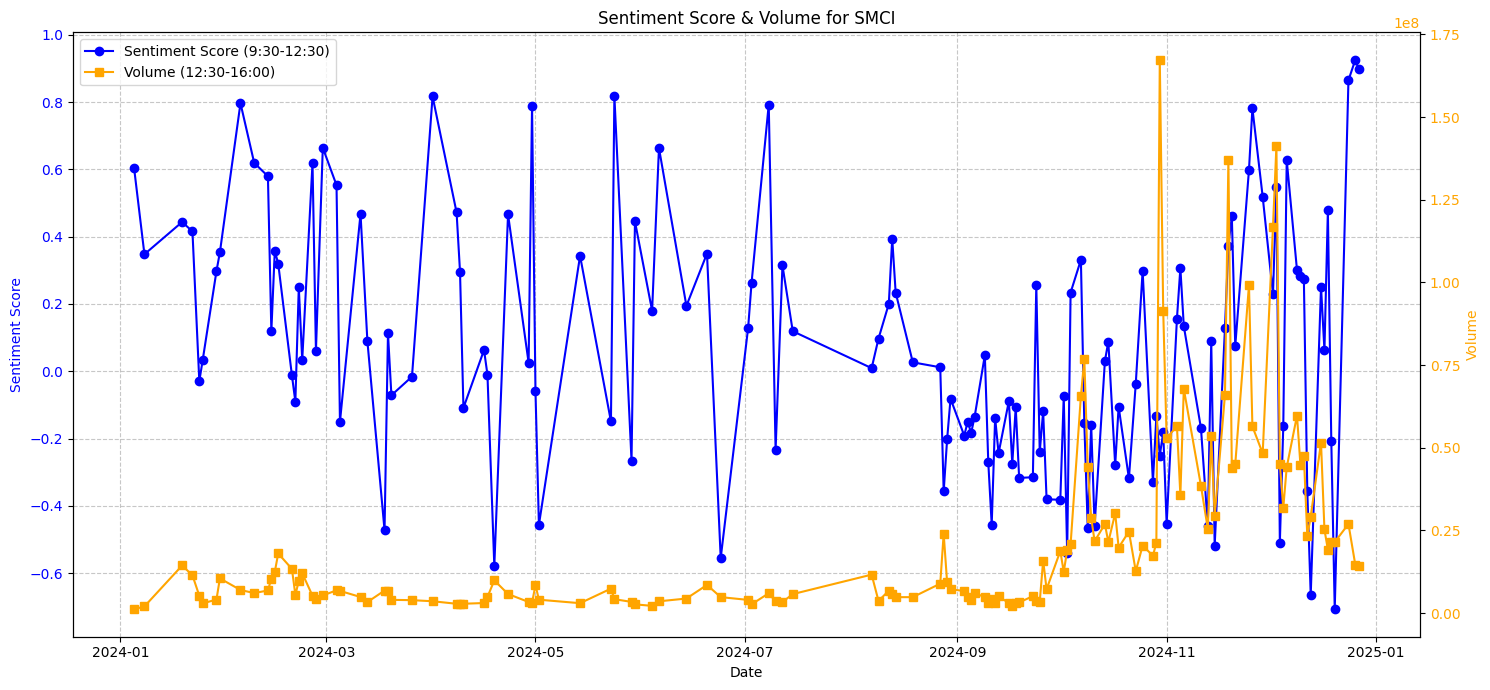

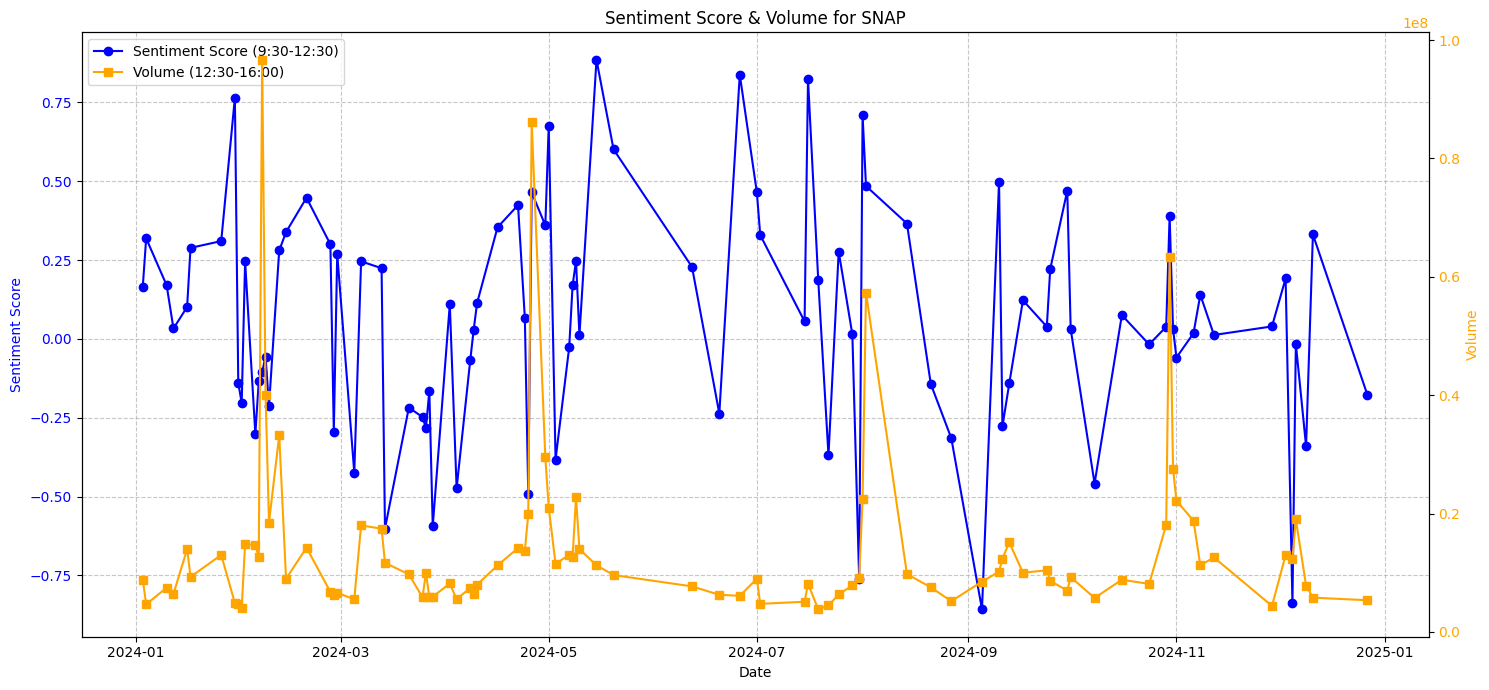

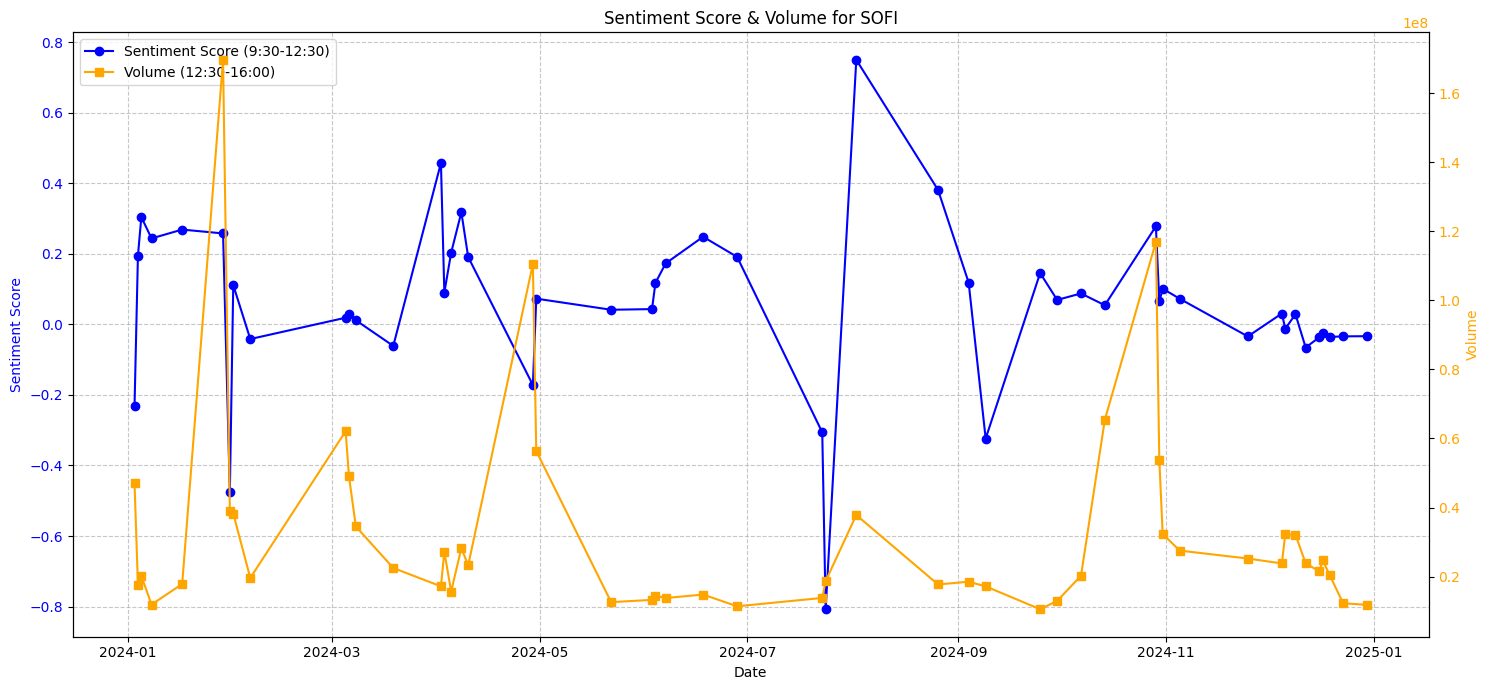

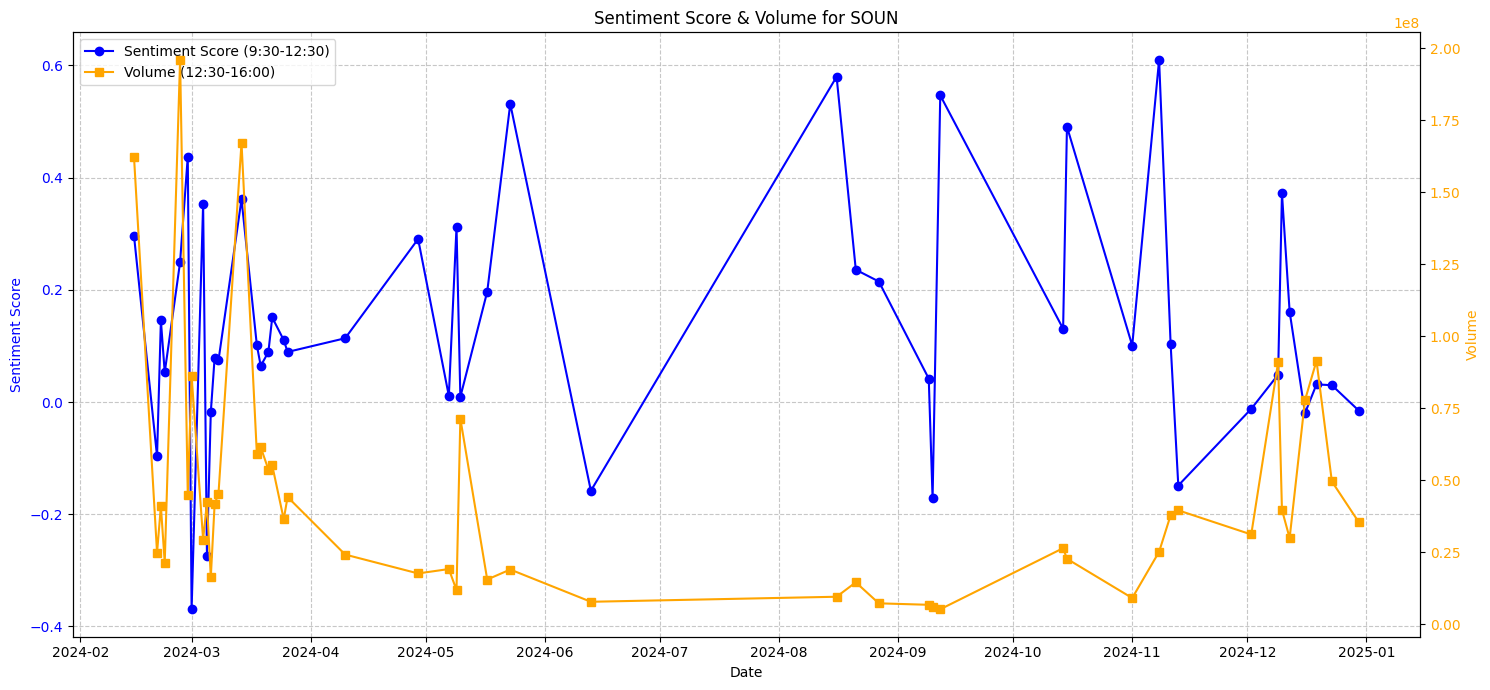

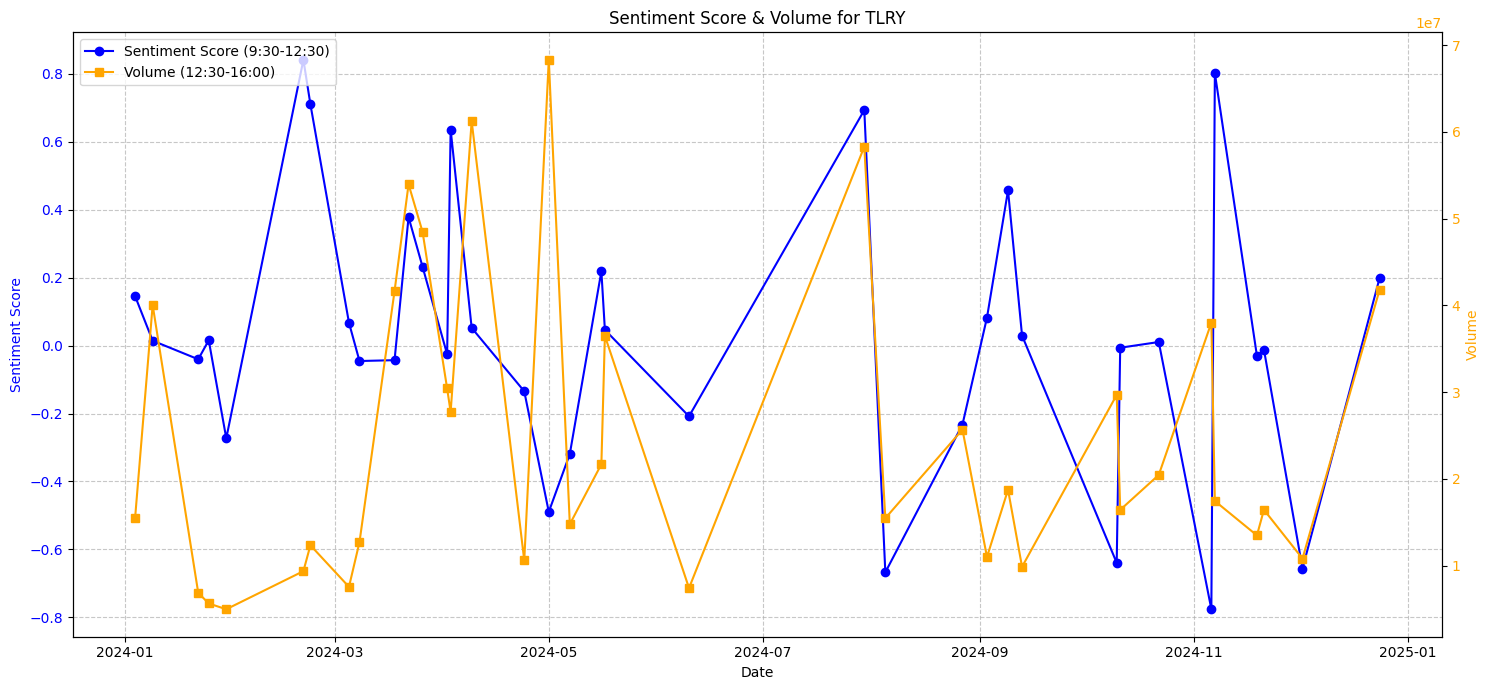

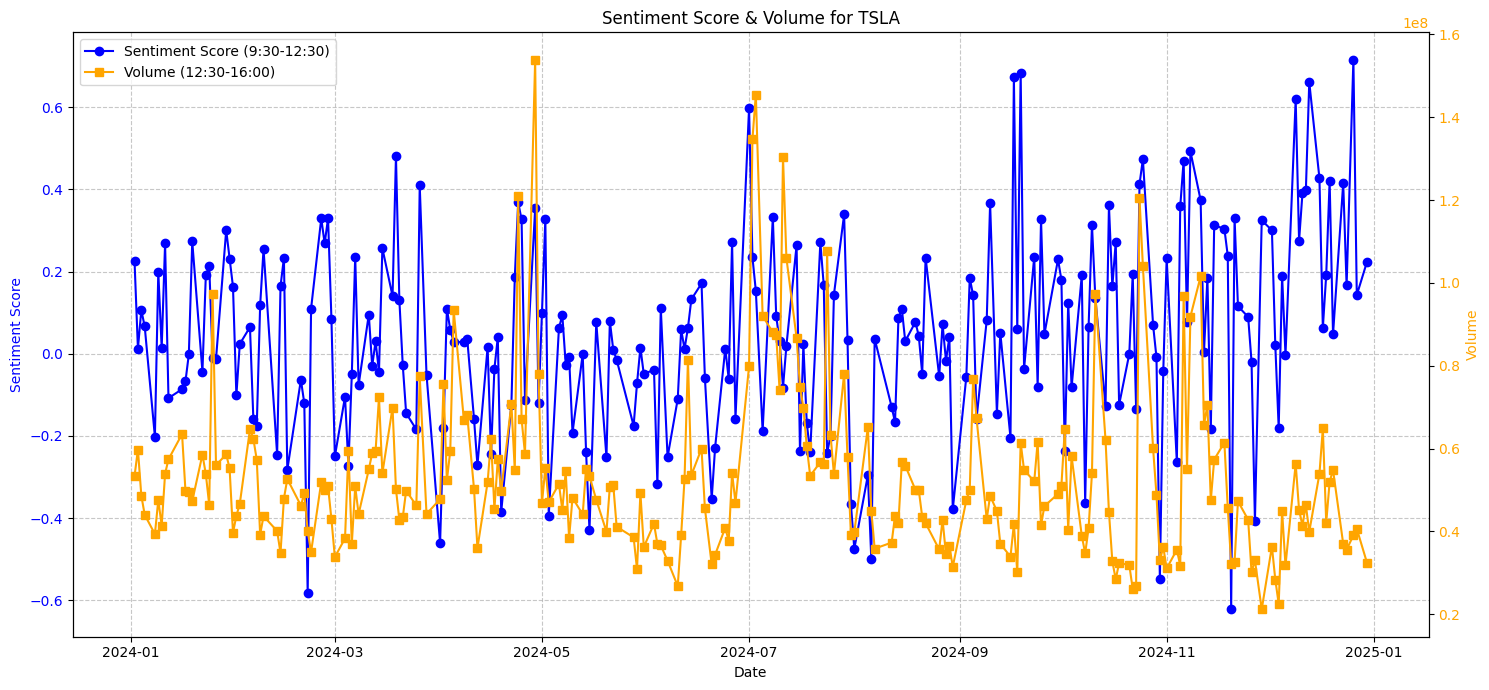

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------- Part 1: Processing Sentiment Data --------------------------
df_sentiment = pd.read_csv('sentiment_results_roberta.csv')

# Convert time column to datetime and calculate sentiment score
df_sentiment['time'] = pd.to_datetime(df_sentiment['time'])
df_sentiment['score'] = -df_sentiment['roberta_neg'] + df_sentiment['roberta_pos']

# Filter data within the 9:30-12:30 time range and aggregate
df_sentiment = df_sentiment[
    (df_sentiment['time'].dt.time >= pd.to_datetime('09:30').time()) & 
    (df_sentiment['time'].dt.time <= pd.to_datetime('12:30').time())
]
df_sentiment['date'] = df_sentiment['time'].dt.date  # Extract date for merging
daily_sentiment = df_sentiment.groupby(['ticker', 'date'])['score'].mean().reset_index()

# -------------------------- Part 2: Processing Trading Volume Data --------------------------
df_volume = pd.read_csv('hourly_volume_data_eastern.csv')

# Convert time column to datetime and filter data within the 12:30-16:00 time range
df_volume['Datetime'] = pd.to_datetime(df_volume['Datetime'])
df_volume = df_volume[
    (df_volume['Datetime'].dt.time >= pd.to_datetime('12:30').time()) & 
    (df_volume['Datetime'].dt.time <= pd.to_datetime('16:00').time())
]
df_volume['date'] = df_volume['Datetime'].dt.date  # Extract date for merging

# Aggregate trading volume per ticker and date
df_volume = df_volume.melt(
    id_vars=['date'], 
    value_vars=df_volume.columns.difference(['Datetime']),  # Select stock columns
    var_name='ticker', 
    value_name='volume'
)
daily_volume = df_volume.groupby(['ticker', 'date'])['volume'].sum().reset_index()

# -------------------------- Part 3: Merging Data and Plotting --------------------------
# Merge sentiment and volume data
merged_df = pd.merge(
    daily_sentiment,
    daily_volume,
    on=['ticker', 'date'],
    how='inner'  # Keep only dates that exist in both datasets
)

# Group by ticker and plot the data
for ticker, group in merged_df.groupby('ticker'):
    plt.figure(figsize=(15, 7))
    
    # Left y-axis: Sentiment Score
    ax1 = plt.gca()
    ax1.plot(group['date'], group['score'], color='blue', marker='o', label='Sentiment Score (9:30-12:30)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sentiment Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Right y-axis: Trading Volume
    ax2 = ax1.twinx()
    ax2.plot(group['date'], group['volume'], color='orange', marker='s', label='Volume (12:30-16:00)')
    ax2.set_ylabel('Volume', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Chart customization
    plt.title(f'Sentiment Score & Volume for {ticker}')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
